# Committeed: A Network and NLP Analysis of the NCAA Men's Basketball Transfer Portal
## Danny Mathieson

In [1]:
#pip install networkx==2.6.3

## The above version of networkX was used with this notebook. Some commands may be unstable with newer versions of networkX

## Import Statements

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import networkx as nx
from scipy.sparse.csgraph import connected_components
from scipy import stats

## Data Instantiation

In [3]:
# Get Transfer Portal Data
df = pd.read_csv('SMA_NCAAM_Data.csv')
df.head()

,Year,Stars,Position,Name,Class,Previous School,New School
0,2021,4.0,SG,Dwayne Cohill,RS SO,Dayton,Youngstown State
1,2021,2.0,SG,Owen Long,SO,Maryville,Youngstown State
2,2021,2.0,SG,Chris Shelton,SO,Hampton,Youngstown State
3,2020,2.0,SG,Greyson Kelley,RS SR,Shaw,Youngstown State
4,2019,3.0,SG,Tyler Foster,JR,East Carolina,Youngstown State


In [4]:
# We'll first look at team performance in 2020, compared to the 2 prior years of transfer portal action
# I chose 2 years to account for players who are forced to sit out for a year due to NCAA eligibility rules. 
# (All players transferred in 2018 are eligible to play in 2020, whereas only some 2019 transfers are elgible)
df1819 = df.loc[(df['Year'] > 2017)].sort_values(by="Stars", ascending=False, ignore_index=True)
df1819 = df1819.loc[(df1819['Year'] < 2020)].sort_values(by="Stars", ascending=False, ignore_index=True)
df1819.head()

,Year,Stars,Position,Name,Class,Previous School,New School
0,2018,5.0,SG,Mustapha Heron,NaN,Auburn,St. John's
1,2019,5.0,PG,"Derryck Thornton, Jr.",RS N/A,USC,Boston College
2,2019,5.0,PG,Quade Green,RS JR,Kentucky,Washington
3,2018,5.0,SF,Brian 'Tugs' Bowen II,SR,Louisville,South Carolina
4,2019,4.7,PF,Jordan Brown,RS SO,Nevada,Arizona


In [5]:
# We'll use the most recent transfer portal action (as of 5/1/22) to analyze sentiment from Twitter
df22= df.loc[(df['Year'] == 2022 )].sort_values(by="Stars", ascending=False, ignore_index=True)

In [6]:
# We need to include the team's statistics from 2020 to compare againse the 18-19 transfer action. 
# Stats are games, wins, off efficiency, def. efficiency, and BARTHAG (metric showing the probabiltiy of beating another D1 team)
df20_stats = pd.read_csv('/Users/dannymathieson/Desktop/Social Media Analytics/Final Project/2020_stats.csv')
df20_stats

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG
0,Kansas,B12,30,28,116.1,87.7,0.9616
1,Baylor,B12,30,26,114.5,88.4,0.9513
2,Gonzaga,WCC,33,31,121.3,94.3,0.9472
3,Dayton,A10,31,29,119.5,93.4,0.9445
4,Michigan St.,B10,31,22,114.8,91.3,0.9326
...,...,...,...,...,...,...,...
348,Arkansas Pine Bluff,SWAC,29,4,80.1,104.3,0.0461
349,Maryland Eastern Shore,MEAC,31,5,82.1,108.0,0.0411
350,Mississippi Valley St.,SWAC,30,4,89.2,119.0,0.0350
351,Kennesaw St.,ASun,29,1,82.2,112.2,0.0269


In [7]:
# Combine Dataframes for D1 schools (only have stats for D1)
df_d1 = pd.merge(df1819, df20_stats, left_on='Previous School', right_on='TEAM')
df_d1 = pd.merge(df_d1, df20_stats, left_on='New School', right_on='TEAM')
df_d1

,Year,Stars,Position,Name,Class,Previous School,New School,TEAM_x,CONF_x,G_x,...,ADJOE_x,ADJDE_x,BARTHAG_x,TEAM_y,CONF_y,G_y,W_y,ADJOE_y,ADJDE_y,BARTHAG_y
0,2018,5.0,SG,Mustapha Heron,NaN,Auburn,St. John's,Auburn,SEC,31,...,111.1,96.1,0.8415,St. John's,BE,32,17,106.8,94.7,0.7992
1,2018,3.0,PF,David Caraher,RS JR,Houston Baptist,St. John's,Houston Baptist,Slnd,29,...,103.5,121.3,0.1388,St. John's,BE,32,17,106.8,94.7,0.7992
2,2019,2.0,PG,Nick Rutherford,RS N/A,Monmouth,St. John's,Monmouth,MAAC,31,...,98.4,101.8,0.4041,St. John's,BE,32,17,106.8,94.7,0.7992
3,2018,4.0,PG,Davion Mitchell,RS JR,Auburn,Baylor,Auburn,SEC,31,...,111.1,96.1,0.8415,Baylor,B12,30,26,114.5,88.4,0.9513
4,2019,2.0,PF,Jonathan Tchamwa Tchatchoua,RS SO,UNLV,Baylor,UNLV,MWC,32,...,107.5,100.1,0.6950,Baylor,B12,30,26,114.5,88.4,0.9513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,2019,2.0,PG,Braden Norris,RS SO,Oakland,Loyola Chicago,Oakland,Horz,32,...,99.1,104.7,0.3485,Loyola Chicago,MVC,31,21,103.8,96.3,0.7031
468,2019,2.0,PG,Tamir Bynum,JR,UTSA,Prairie View A&M,UTSA,CUSA,29,...,104.0,107.5,0.4049,Prairie View A&M,SWAC,30,19,95.2,101.6,0.3203
469,2019,2.0,SG,Parker Edwards,RS SO,Southeastern Louisiana,LSU,Southeastern Louisiana,Slnd,28,...,93.1,108.2,0.1514,LSU,SEC,31,21,118.2,102.5,0.8373
470,2019,2.0,PG,Jose Placer,RS SO,UMBC,North Florida,UMBC,AE,29,...,97.6,106.2,0.2735,North Florida,ASun,31,21,112.3,110.8,0.5372


In [8]:
# Dataframe for all transfer action (D1, D2, D3)
df_all=df1819.dropna(axis=0) # Drops athletes who were not picked up by a new school
df_all

,Year,Stars,Position,Name,Class,Previous School,New School
1,2019,5.0,PG,"Derryck Thornton, Jr.",RS N/A,USC,Boston College
2,2019,5.0,PG,Quade Green,RS JR,Kentucky,Washington
3,2018,5.0,SF,Brian 'Tugs' Bowen II,SR,Louisville,South Carolina
4,2019,4.7,PF,Jordan Brown,RS SO,Nevada,Arizona
5,2018,4.7,PF,"Carlton Bragg, Jr.",RS N/A,Arizona State,Arizona State
...,...,...,...,...,...,...,...
1865,2018,2.0,PG,Perris Hicks,RS N/A,Fordham,Nyack
1866,2019,2.0,SF,Bryce Schneider,RS JR,Richmond,Nova Southeastern
1867,2019,2.0,PG,Matt Weir,SR,Purdue Fort Wayne,Nova Southeastern
1868,2018,2.0,SG,Mark Matthews,RS N/A,Florida Gulf Coast,Nova Southeastern


# Network Analytics

## In the network below, nodes represent teams and edges represent players transferred between them. The edge weights are determined by the players "Star Ranking" a measure of their play ability

In [9]:
def graph(data):
    G= nx.from_pandas_edgelist(data, 'Previous School', 'New School', edge_attr=['Stars'], 
                             create_using=nx.MultiDiGraph())
    nx.set_node_attributes(G, df20_stats.set_index('TEAM').to_dict('index'))
    #G.nodes(data=True)
    return G

In [10]:
# Create graphs for each df. We'll look at graph analytics for 18-19 D1 and all transfers to better understand the network, then use some graph metrics from 2022 for sentiment analyis
mdg_d1= graph(df_d1)
mdg_all= graph(df_all)
mdg_22= graph(df22)

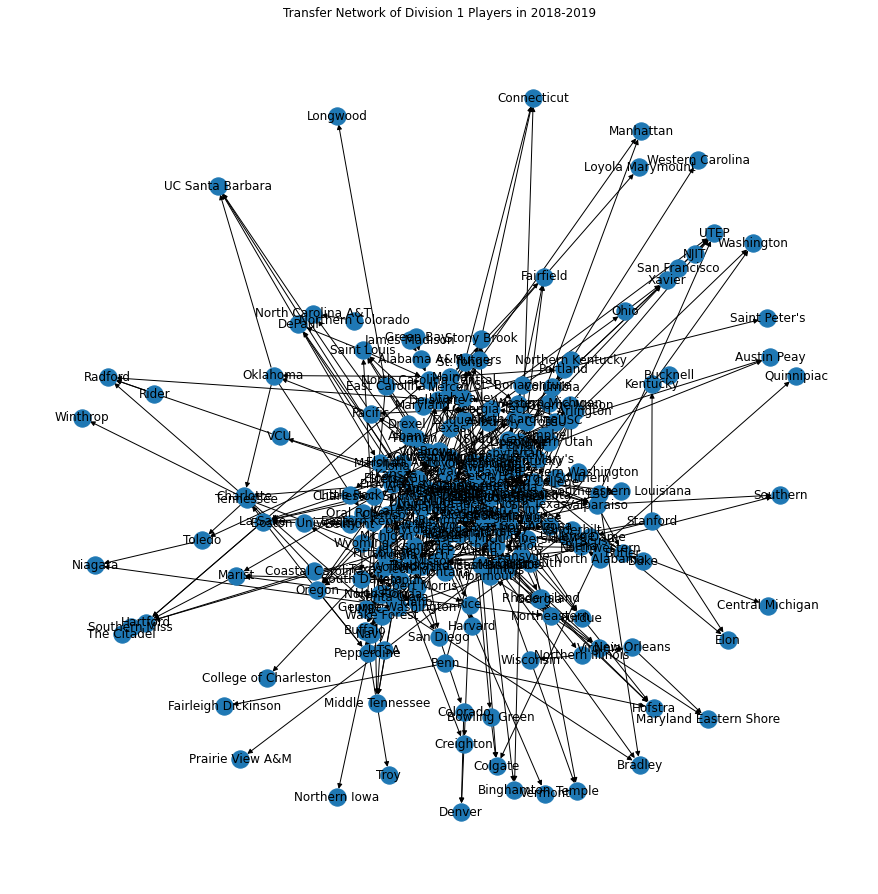

In [11]:
plt.figure(3,figsize=(12,12)) 
pos = nx.spring_layout(mdg_d1)
nx.draw(mdg_d1, pos, with_labels=True)
plt.title("Transfer Network of Division 1 Players in 2018-2019")
plt.show()

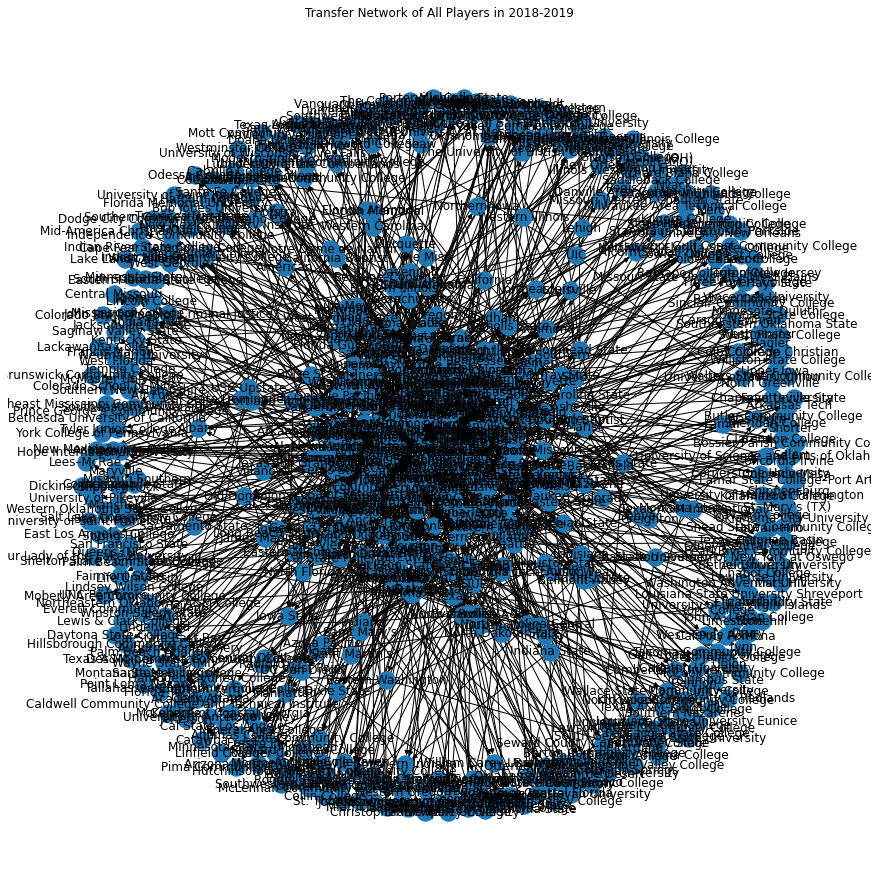

In [12]:
plt.figure(3,figsize=(12,12)) 
pos = nx.spring_layout(mdg_all)
nx.draw(mdg_all, pos, with_labels=True)
plt.title("Transfer Network of All Players in 2018-2019")
plt.show()

In [13]:
# Write graphs to Gephi for visualization
# Commented out for grader

# nx.write_gexf(mdg_d1, "mdgd1_Gephi.gexf")
# nx.write_gexf(mdg_all, "mdgall_Gephi.gexf")

In [14]:
#number of nodes and edges, diameter of graph, shortest path for D1
print ("D1 Graph Size")
print ("This graph has {} nodes".format(str(mdg_d1.number_of_nodes())))
print ("This graph has {} edges".format(str(mdg_d1.number_of_edges())))

D1 Graph Size
This graph has 237 nodes
This graph has 472 edges


In [15]:
#number of nodes and edges, diameter of graph, shortest path for all transfers
print ("All Transfers Graph Size")
print ("This graph has {} nodes".format(str(mdg_all.number_of_nodes())))
print ("This graph has {} edges".format(str(mdg_all.number_of_edges())))

All Transfers Graph Size
This graph has 766 nodes
This graph has 1585 edges


In [16]:
print(nx.number_strongly_connected_components(mdg_all))

514


In [17]:
print(nx.number_weakly_connected_components(mdg_all))

3


In [18]:
largest = max(nx.strongly_connected_components(mdg_all), key=len)
print(len(largest))

253


In [19]:
largest = max(nx.weakly_connected_components(mdg_all), key=len)
print(len(largest))

762


## All transfers gives us a larger graph, so let's explore this network further

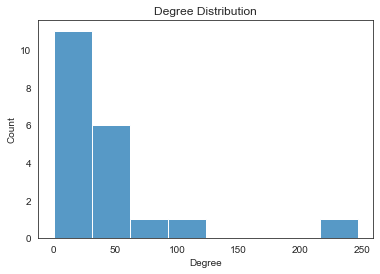

In [20]:
sns.set_style("white")
fig = sns.histplot(nx.degree_histogram(mdg_all));
fig.set_title("Degree Distribution")
fig.set_xlabel("Degree");

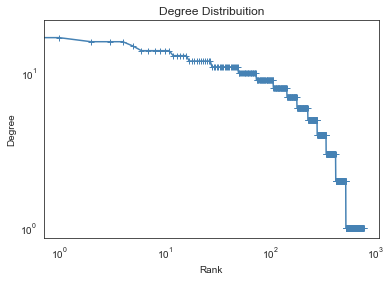

In [21]:
degree_dist=sorted(dict(nx.degree(mdg_all)).values(),reverse=True) 
plt.loglog(degree_dist, "steelblue", marker="+");
plt.title("Degree Distribuition")
plt.ylabel("Degree")
plt.xlabel("Rank");

The degree centrality of this graph is 0.0054096486288161905


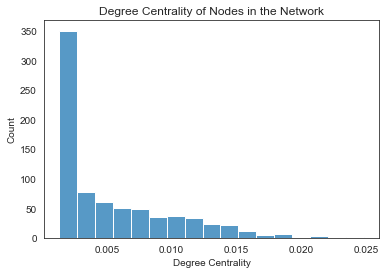

In [22]:
dc = np.mean(list(nx.degree_centrality(mdg_all).values()))
print ("The degree centrality of this graph is {}".format(str(dc)))
fig = sns.histplot(nx.degree_centrality(mdg_all))
fig.set_title("Degree Centrality of Nodes in the Network")
fig.set_xlabel("Degree Centrality");

In [23]:
dc_nodes = sorted(nx.degree_centrality(mdg_all), key=nx.degree_centrality(mdg_all).get, reverse=True)[:5]
print("The nodes with the highest degree centrality are " + str(dc_nodes))

The nodes with the highest degree centrality are ['UTEP', 'Chattanooga', 'GCU', 'Texas Southern', 'Utah Valley']


The closeness centrality of this graph is 0.05457475228070008


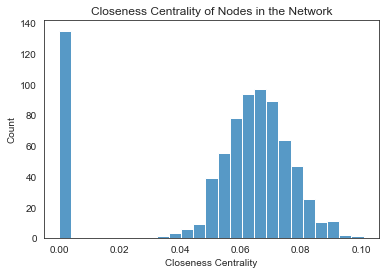

In [24]:
cc = np.mean(list(nx.closeness_centrality(mdg_all).values()))
print ("The closeness centrality of this graph is {}".format(str(cc)))
fig = sns.histplot(nx.closeness_centrality(mdg_all))
fig.set_title("Closeness Centrality of Nodes in the Network")
fig.set_xlabel("Closeness Centrality");

## Evaluating Performance of Teams in Transfer Portal: PageRank, Net Degree (In-Out), and Gross Degree (In+Out)

In [25]:
# The cells below are exploratory analysis of what teams performed well in the transfer portal. We look at several metrics across graphs to see what teams are included in the list.
# We'll then compare those teams 2020 performance to the various metrics to see which metric correlates with team performance


# A high net ranking means a team acquired players with more stars, and lost few players (or lost players with few stars)
# Gross rankings are indicative of that teams total transfer volume, or turnover

In [26]:
pg_rank=sorted([l for l in nx.pagerank(mdg_all, weight='Stars').items()],key=lambda x: x[1],reverse=True)
print("Top 10 Teams from All By Pagerank",pg_rank[:10])

Top 10 Teams from All By Pagerank [('Winthrop', 0.004977936008398342), ('American International', 0.0046300243674521485), ('Pima Community College', 0.0044471200588177525), ('UC San Diego', 0.004416461595376721), ('Nicholls State', 0.004414806606627544), ('Salt Lake Community College', 0.004402976494148782), ('Detroit Mercy', 0.004218834835304958), ('La Salle', 0.004073021587355136), ('Barry', 0.0036126559584844344), ('South Plains College', 0.0035960592703254907)]


In [27]:
pg_rank=sorted([l for l in nx.pagerank(mdg_d1, weight='Stars').items()],key=lambda x: x[1],reverse=True)
print("Top 10 Teams from All By Pagerank",pg_rank[:10])

Top 10 Teams from All By Pagerank [('Hartford', 0.01990767148811447), ('The Citadel', 0.018059071984331924), ("Mount St. Mary's", 0.017767603601787127), ('Delaware', 0.01702372038422218), ('South Carolina', 0.015600834337771787), ('La Salle', 0.014370974741920962), ('Santa Clara', 0.01420097763164325), ('Clemson', 0.013906402473267417), ('Wake Forest', 0.013813750477402782), ('Texas Southern', 0.013487616337641534)]


In [28]:
transfer_gross_d1 = sorted(mdg_d1.degree(weight='Stars'),key=lambda l:l[1], reverse=True)
print("D1 Gross Top Transfer Teams")
print(transfer_gross_d1[:10])

D1 Gross Top Transfer Teams
[('South Carolina', 34.2), ('Nevada', 30.6), ('Texas Tech', 29.4), ('Clemson', 28.2), ('Alabama', 27.9), ("St. John's", 27.3), ('Arkansas', 26.3), ('Chattanooga', 26.1), ('Nebraska', 26.0), ('La Salle', 26.0)]


In [29]:
transfer_gross_all = sorted(mdg_all.degree(weight='Stars'),key=lambda l:l[1], reverse=True)
print("All Gross Top Transfer Teams")
print(transfer_gross_all[:10])

All Gross Top Transfer Teams
[('UTEP', 44.2), ('Texas Tech', 40.8), ('GCU', 40.0), ('Nevada', 39.9), ('Chattanooga', 38.1), ('DePaul', 37.599999999999994), ('UNLV', 37.3), ('Texas Southern', 37.0), ('South Carolina', 36.2), ('Florida Gulf Coast', 35.7)]


In [30]:
transfer_gross_d1 = sorted(mdg_d1.degree(weight='Stars'),key=lambda l:l[1], reverse=True)
print("D1 Gross Bottom Transfer Teams")
print(transfer_gross_d1[-10:])

D1 Gross Bottom Transfer Teams
[('Navy', 2.0), ('Longwood', 2.0), ("Saint Peter's", 2.0), ('Loyola Marymount', 2.0), ('Green Bay', 2.0), ('James Madison', 2.0), ('Fairleigh Dickinson', 2.0), ('The Citadel', 2.0), ('Prairie View A&M', 2.0), ('Wofford', 2.0)]


In [31]:
transfer_gross_all = sorted(mdg_all.degree(weight='Stars'),key=lambda l:l[1], reverse=True)
print("All Gross Bottom Transfer Teams")
print(transfer_gross_all[-10:])

All Gross Bottom Transfer Teams
[('Ramapo College of New Jersey', 2.0), ('Oklahoma City University', 2.0), ('Rochester College', 2.0), ('Pima Community College', 2.0), ('Queens (NC)', 2.0), ('Purdue Northwest', 2.0), ('Northwestern Oklahoma State', 2.0), ('Olney Central College', 2.0), ('Pensacola State College', 2.0), ('Notre Dame (OH)', 2.0)]


In [32]:
transfer_losses_d1 = sorted(mdg_d1.out_degree(weight='Stars'),key=lambda l:l[1], reverse=True)
print("D1 Bottom Transfer Teams")
print(transfer_losses_d1[:10])

D1 Bottom Transfer Teams
[('Alabama', 20.3), ('USC', 18.7), ("St. John's", 17.3), ('South Carolina', 17.2), ('Kansas', 16.7), ('Utah', 15.8), ('Texas A&M', 15.7), ('Stanford', 15.600000000000001), ('Duquesne', 15.5), ('Pittsburgh', 14.7)]


In [33]:
transfer_gains_d1 = sorted(mdg_d1.in_degree(weight='Stars'),key=lambda l:l[1], reverse=True)
print("D1 Top Transfer Teams")
print(transfer_gains_d1[:10])

D1 Top Transfer Teams
[('Texas Southern', 22.0), ('Arizona', 20.4), ('Texas Tech', 17.7), ('Clemson', 17.7), ('UCF', 17.3), ('South Carolina', 17.0), ('South Alabama', 17.0), ('La Salle', 17.0), ('UTEP', 16.5), ('Nevada', 16.2)]


In [34]:
transfer_losses_all = sorted(mdg_all.out_degree(weight='Stars'),key=lambda l:l[1], reverse=True)
print("All Bottom Transfer Teams")
print(transfer_losses_all[:10])

All Bottom Transfer Teams
[('Utah', 29.5), ('Florida Gulf Coast', 25.7), ('Massachusetts', 24.3), ('Texas Tech', 23.1), ('UTEP', 23.0), ('Oregon State', 22.7), ('West Virginia', 21.8), ('DePaul', 21.4), ('Chattanooga', 21.3), ('LSU', 21.0)]


In [35]:
transfer_gains_all = sorted(mdg_all.in_degree(weight='Stars'),key=lambda l:l[1], reverse=True)
print("All Top Transfer Teams")
print(transfer_gains_all[:10])

All Top Transfer Teams
[('Texas Southern', 27.0), ('New Mexico Junior College', 24.0), ('GCU', 23.0), ('South Plains College', 22.5), ('UTEP', 21.2), ('Arizona', 20.4), ('Northwest Florida State College', 20.0), ('Utah Valley', 20.0), ('Salt Lake Community College', 19.5), ('Tallahassee Community College', 19.3)]


In [36]:
transfer_gains_22 = sorted(mdg_22.in_degree(weight='Stars'),key=lambda l:l[1], reverse=True)
print("All Top Transfer Teams")
print(transfer_gains_22[1:10]) # Removes nan from players who have not yet secured a new tea,

All Top Transfer Teams
[('Missouri State', 18.0), ('Massachusetts', 18.0), ('Bryant', 18.0), ('Providence', 17.0), ('Arkansas', 15.0), ('Florida Gulf Coast', 14.0), ('Western Kentucky', 13.0), ('UAB', 13.0), ('Georgia', 12.0)]


In [37]:
transfer_losses_22 = sorted(mdg_22.out_degree(weight='Stars'),key=lambda l:l[1], reverse=True)
print("D1 Bottom Transfer Teams")
print(transfer_losses_22[:10])

D1 Bottom Transfer Teams
[('LSU', 34.3), ('La Salle', 32.0), ('Kansas State', 32.0), ('Memphis', 29.0), ('Milwaukee', 28.5), ('Mississippi State', 27.0), ('New Mexico State', 26.3), ('Prairie View A&M', 26.0), ('Missouri', 25.8), ('Alabama State', 24.6)]


In [38]:
transfer_gross_22= sorted(mdg_22.degree(weight='Stars'),key=lambda l:l[1], reverse=True)
print("All Top Transfer Teams")
print(transfer_gross_22[1:10]) # Removes nan from players who have not yet secured a new tea,

All Top Transfer Teams
[('LSU', 45.3), ('Missouri State', 39.0), ('Kansas State', 39.0), ('Missouri', 36.8), ('Memphis', 35.0), ('Georgia', 35.0), ('La Salle', 34.0), ('UTEP', 33.5), ('Mississippi State', 33.0)]


In [39]:
transfer_gross_22= sorted(mdg_22.degree(weight='Stars'),key=lambda l:l[1], reverse=True)
print("All Top Transfer Teams")
print(transfer_gains_22[-10:]) # Removes nan from players who have not yet secured a new tea,

All Top Transfer Teams
[('Mary', 0), ('Anderson', 0), ('Appalachian State', 0), ('Glenville State', 0), ('Cal Poly Pomona', 0), ('Marquette', 0), ('Southern New Hampshire', 0), ('Gonzaga', 0), ('Yale', 0), ('Tusculum', 0)]


In [40]:
def portal_net_score (loss, gain):
    loss_dict = dict(loss)
    gains_dict = dict(gain)
    net_gains_losses= {key: gains_dict[key] - loss_dict.get(key, 0) for key in gains_dict}
    net_gains_losses = {k: v for k, v in sorted(net_gains_losses.items(), key=lambda item: -item[1])}
    return list(net_gains_losses.items())

In [41]:
def portal_gross_score (loss, gain):
    loss_dict = dict(loss)
    gains_dict = dict(gain)
    net_gains_losses= {key: gains_dict[key] + loss_dict.get(key, 0) for key in gains_dict}
    net_gains_losses = {k: v for k, v in sorted(net_gains_losses.items(), key=lambda item: -item[1])}
    return list(net_gains_losses.items())

In [42]:
gross_d1 = portal_gross_score(transfer_losses_d1, transfer_gains_d1)
net_d1 = portal_net_score(transfer_losses_d1, transfer_gains_d1)


In [43]:
net=pd.DataFrame(net_d1, columns = ['TEAM', 'Net'])
gross=pd.DataFrame(gross_d1, columns = ['TEAM', 'Gross'])


In [44]:
pg_rank_d1=sorted([l for l in nx.pagerank(mdg_d1, weight='Stars').items()],key=lambda x: x[1],reverse=True)
prdf=pd.DataFrame(pg_rank_d1, columns = ['TEAM', 'PageRank'])
prdf

,TEAM,PageRank
0,Hartford,0.019908
1,The Citadel,0.018059
2,Mount St. Mary's,0.017768
3,Delaware,0.017024
4,South Carolina,0.015601
...,...,...
232,Eastern Washington,0.001131
233,Navy,0.001131
234,Green Bay,0.001131
235,James Madison,0.001131


## Examining Trends between transfer performance and team performance to select the best metric for transfer performance

In [45]:
trend_df = pd.merge(net, df20_stats, on='TEAM')

In [46]:
trend_df = pd.merge(trend_df, gross, on='TEAM')

In [47]:
trend_df = pd.merge(trend_df, prdf, on='TEAM')

In [48]:
trend_df

,TEAM,Net,CONF,G,W,ADJOE,ADJDE,BARTHAG,Gross,PageRank
0,Texas Southern,20.0,SWAC,31,16,98.4,109.8,0.2216,24.0,0.013488
1,Arizona,18.4,P12,32,21,110.9,91.2,0.9040,22.4,0.008619
2,UTEP,16.5,CUSA,29,17,96.7,98.6,0.4439,16.5,0.009431
3,South Alabama,12.5,SB,28,20,104.3,103.6,0.5185,21.5,0.008756
4,Utah Valley,12.0,WAC,27,11,96.1,104.2,0.2843,16.0,0.007984
...,...,...,...,...,...,...,...,...,...,...
232,Duquesne,-13.5,A10,30,21,107.0,98.9,0.7118,17.5,0.007919
233,USC,-14.7,P12,31,22,103.6,91.9,0.7990,22.7,0.004091
234,Stanford,-15.6,P12,32,20,104.2,90.7,0.8315,15.6,0.001131
235,Texas A&M,-15.7,SEC,30,16,101.2,97.4,0.6083,15.7,0.001131


/Users/dannymathieson/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


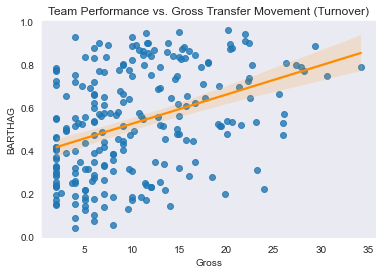

In [49]:
sns.set_style("dark")

fig = sns.regplot(trend_df.Gross, trend_df.BARTHAG,line_kws={"color": "darkorange"}) 

fig.set_title("Team Performance vs. Gross Transfer Movement (Turnover)");

In [50]:
# Equation of regression line above
stats.linregress(trend_df.Gross, trend_df.BARTHAG)

LinregressResult(slope=0.013615183109682273, intercept=0.3900637807834745, rvalue=0.388204564740142, pvalue=6.048095690827262e-10, stderr=0.0021084279649776013, intercept_stderr=0.026554349139874433)

/Users/dannymathieson/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


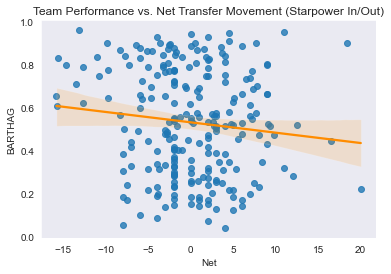

In [51]:
fig = sns.regplot(trend_df.Net, trend_df.BARTHAG,line_kws={"color": "darkorange"}) 
fig.set_title("Team Performance vs. Net Transfer Movement (Starpower In/Out)");

/Users/dannymathieson/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


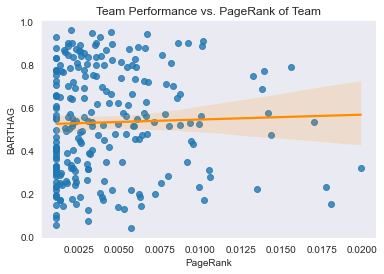

In [52]:
fig = sns.regplot(trend_df.PageRank, trend_df.BARTHAG,line_kws={"color": "darkorange"}) 
fig.set_title("Team Performance vs. PageRank of Team");

## As Shown above, gross transfer movement shows highest correlation to team performance. (Teams with high turnover perform better)

## These are the teams that we'll look into for Twitter, based on their 2022 transfer performace

In [53]:
net_22 = portal_net_score(transfer_losses_22, transfer_gains_22)
print("Net Winners 2022")
net_22[1:6]

Net Winners 2022


[('Massachusetts', 14.0),
 ('Western New Mexico', 9.0),
 ('Providence', 8.0),
 ('North Texas', 7.0),
 ('Bryant', 6.5)]

In [54]:
print("Net Losers 2022")
net_22[-6:] # Let's use Memphis over Chicago State due to tied score and notoriety

Net Losers 2022


[('Memphis', -23.0),
 ('Chicago State', -23.0),
 ('LSU', -23.299999999999997),
 ('Kansas State', -25.0),
 ('Milwaukee', -26.5),
 ('La Salle', -30.0)]

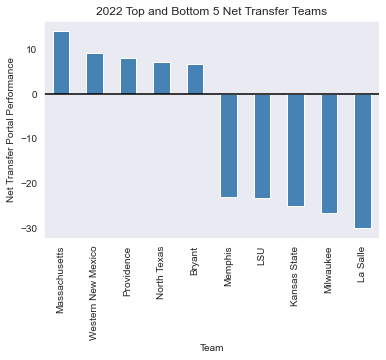

In [55]:
hist=net_22[1:6]+net_22[-6:]
hist_df = pd.DataFrame(hist)
hist_df.set_index(0, inplace=True)

hist_df.drop('Chicago State',inplace=True) # Tied Score, we'll use LSU over CSU

x= hist_df[1]

fig = hist_df.plot(kind='bar',color = 'steelblue', legend=False)
plt.axhline(y=0, color='black')
fig.set_ylabel("Net Transfer Portal Performance");
fig.set_xlabel("Team");
fig.set_title("2022 Top and Bottom 5 Net Transfer Teams");

# Analyzing Sentiment of Teams compared to Transfer portal performance

## Identify top and bottom 5 teams in the transfer portal in 2022 (and the players involved) to design Twitter query

In [56]:
# Top 5 transfer teams - the top is excluded becuase it represents no team (when players transfer out, but haven't found a new school)
net_22[:6]

[(nan, 2402.5),
 ('Massachusetts', 14.0),
 ('Western New Mexico', 9.0),
 ('Providence', 8.0),
 ('North Texas', 7.0),
 ('Bryant', 6.5)]

In [57]:
# Bottom 5 teams
net_22[-6:]

[('Memphis', -23.0),
 ('Chicago State', -23.0),
 ('LSU', -23.299999999999997),
 ('Kansas State', -25.0),
 ('Milwaukee', -26.5),
 ('La Salle', -30.0)]

In [58]:
def get_players (inORout,Team):
    x = df22.loc[df22[inORout] == Team]
    return list(x.Name)

In [59]:
get_players("New School", "Massachusetts")

['Wildens Leveque',
 'Matt Cross',
 'Rahsool Diggins',
 'TaQuan Woodley',
 'Gianni Thompson']

In [60]:
get_players("New School", "Western New Mexico")

['D.J. Heath', 'Jordan Preaster', 'Isaiah Lewis', 'Emmanuel White']

In [61]:
get_players("New School", "Providence")

['Clifton Moore',
 'Bryce Hopkins',
 'Corey Floyd, Jr.',
 'Noah Locke',
 'Devin Carter']

In [62]:
get_players("New School", "North Texas")

['Moulaye Sissoko', 'Jayden Martinez', 'Kai Huntsberry', 'Tyree Eady']

In [63]:
get_players("New School", "Bryant")

['Sherif Kenney',
 'Earl Timberlake',
 'Antwan Walker',
 'Kvonn Cramer',
 'Chauncey Hawkins',
 'Joel Kabimba',
 'Doug Edert']

## Players for Bottom 5 Schools

In [64]:
get_players("Previous School", "Memphis")

['Emoni Bates',
 'Josh Minott',
 'Landers Nolley II',
 'Sam Onu',
 'Earl Timberlake',
 'John Camden',
 'Tyler Harris']

In [65]:
get_players("Previous School", "LSU")

['Efton Reid III',
 "Shareef O'Neal",
 'Adam Miller',
 'Jerrell Colbert',
 'Eric Gaines',
 'Alex Fudge',
 'Brandon Murray',
 'Xavier Pinson',
 'Bradley Ezewiro']

In [66]:
get_players("Previous School", "Kansas State")

['Montavious Murphy',
 'Carlton Linguard',
 'Nijel Pack',
 'Davion Bradford',
 'Seryee Lewis',
 'Logan Landers',
 'Selton Miguel',
 'Drew Honas',
 'Luke Kasubke',
 'Kaosi Ezeagu',
 'Maximus Edwards']

In [67]:
get_players("Previous School", "Milwaukee")

['Patrick Baldwin, Jr.',
 'Jordan Lathon',
 'Joey St. Pierre',
 'Donovan Newby',
 'Nick Pappas',
 'Kyle Ross',
 'Tafari Simms',
 'Jasin Sinani',
 'Devon Hancock',
 'Samba Kane',
 'Tyler Ellingson',
 'DeAndre Gholston']

In [68]:
get_players("Previous School", "La Salle")

['Clifton Moore',
 'Sherif Kenney',
 'Mamadou Doucouré',
 'Jack Clark',
 'Tegra Izay',
 'Matt McFarlane',
 'Derrius Ward',
 'Kyle Thompson',
 'Christian Ray',
 'Khalil Brantley',
 'Jhamir Brickus',
 'Brandon Dwyer']

In [69]:
df22.loc[df22['Previous School'] == 'LSU']

,Year,Stars,Position,Name,Class,Previous School,New School
5,2022,5.0,C,Efton Reid III,FR,LSU,NaN
9,2022,4.3,PF,Shareef O'Neal,RS SO,LSU,NaN
30,2022,4.0,PG,Adam Miller,FR,LSU,NaN
89,2022,4.0,C,Jerrell Colbert,FR,LSU,Kansas State
126,2022,4.0,PG,Eric Gaines,FR,LSU,UAB
128,2022,4.0,SF,Alex Fudge,FR,LSU,Florida
179,2022,3.0,SG,Brandon Murray,FR,LSU,Georgetown
212,2022,3.0,PG,Xavier Pinson,JR,LSU,NaN
274,2022,3.0,PF,Bradley Ezewiro,FR,LSU,NaN


In [70]:
import tweepy
import pandas as pd

import nltk
from nltk import tokenize, sentiment, corpus, stem
from gensim import corpora, models

from collections import Counter

## The following code is edited for each run, and subsequent CSVs are saved for each school

## The grader will not need to run these cells, as CSVs of scraped Tweets are saved in project folder

In [71]:
# filename = "Saved_LaSalle_Tweets.csv"
# queries =  get_players("Previous School", "LSU")
# school = "LSU"
# q=""
# for i in range (len(queries)): 
#     q+='"'+queries[i]+ '" ' +school + ' OR '
    

# q+=  school + ' basketball'
# q

In [72]:
# bearer = "AAAAAAAAAAAAAAAAAAAAAHJOaAEAAAAAtpbHTZ936h9COqGzIjaHhORUukA%3DMYnWqM9CUgxSU1nLyLe2ARWrRUElckwVYF7fywvBrL2ui0Xj9j"
# client = tweepy.Client(bearer_token=bearer, wait_on_rate_limit=True)

# def get_tweets(client, input_query, n=1000):
#     page_size = 100
#     pages = n // 100 + 1
#     for tweet_batch in tweepy.Paginator(client.search_recent_tweets, query,
#                                       tweet_fields=["created_at", "public_metrics", "entities"],
#                                        expansions=["author_id"],
#                                       user_fields=["username", "public_metrics"],
#                                       max_results=page_size, limit=pages):
#         user_lookup = {u.id: u.data for u in tweet_batch.includes["users"]}
#         for tweet in tweet_batch.data:
#             data = tweet.data
#             data["author"] = user_lookup[tweet.author_id]
#             yield tweet.data
# query = q
# tweets = list(get_tweets(client, query))
# dataset = []
# for tweet in get_tweets(client, query):
#     datum = {
#         "id": tweet["id"],
#         "username": tweet["author"]["username"],
#         "user_followers_count": tweet["author"]["public_metrics"]["followers_count"],
#         "user_following_count": tweet["author"]["public_metrics"]["following_count"],
#         "text": tweet["text"],
#         "created_at": tweet["created_at"],
#         "retweet_count": tweet["public_metrics"]["retweet_count"],
#     }


#     if "entities" in tweet and "mentions" in tweet["entities"]:
#         mentions = tweet["entities"]["mentions"]
#     else:
#         mentions = []

#     datum['mentioned_user_ids'] = ','.join(mention['id'] for mention in mentions)
#     datum['mentioned_user_names'] = ','.join(mention['username'] for mention in mentions)


#     if "entities" in tweet and "hashtags" in tweet["entities"]:
#         mentions = tweet["entities"]["hashtags"]
#     else:
#         mentions = []
#     datum['hashtags'] = ','.join(mention['tag'] for mention in mentions)

#     if "entities" in tweet and "urls" in tweet["entities"]:
#         mentions = tweet["entities"]["urls"]
#     else:
#         mentions = []
#     datum['urls'] = ','.join(mention["expanded_url"] for mention in mentions)

#     dataset += [datum]
# df = pd.DataFrame.from_dict(dataset)
# df.to_csv(filename)

In [73]:
df_bryant = pd.read_csv("Saved_Bryant_Tweets.csv")
df_ksu = pd.read_csv("Saved_KSU_Tweets.csv")
df_lasal = pd.read_csv("Saved_LaSalle_Tweets.csv")
df_lsu = pd.read_csv("Saved_LSU_Tweets.csv")
df_memphis = pd.read_csv("Saved_Memphis_Tweets.csv")
df_mil = pd.read_csv("Saved_Mil_Tweets.csv")
df_nt = pd.read_csv("Saved_NorthTexas_Tweets.csv")
df_prov = pd.read_csv("Saved_Providence_Tweets.csv")
df_umass = pd.read_csv("Saved_Umass_Tweets.csv")
df_wnm = pd.read_csv("Saved_WNM_Tweets.csv")

In [74]:
df_lsu.head() # preview of tweet df

,Unnamed: 0,id,username,user_followers_count,user_following_count,text,created_at,retweet_count,mentioned_user_ids,mentioned_user_names,hashtags,urls
0,0,1521852952121589761,jaayy2live,500,37,RT @ZagMBB: Welcome to the family @efton15 \n📰...,2022-05-04T14:03:13.000Z,41,"602989093,3047170613","ZagMBB,efton15",NaN,"https://bit.ly/3OO84l4,https://twitter.com/Zag..."
1,1,1521851180938416130,AHatfieldii,510,4995,RT @KentuckyWBB: .@eniyar1 chose to #CommitToI...,2022-05-04T13:56:10.000Z,43,"56402878,1195858450900799488","KentuckyWBB,eniyar1","CommitToIt,BBN,BlueMagic","https://bit.ly/3MJpcGF,https://twitter.com/Ken..."
2,2,1521818094984998915,Bayouself5,150,547,RT @lsutigerswire: The Tigers added one of the...,2022-05-04T11:44:42.000Z,1,1201891001737990144,lsutigerswire,NaN,https://lsutigerswire.usatoday.com/lists/lsu-b...
3,3,1521761551224655872,lsutigerswire,310,28,The Tigers added one of the top players in the...,2022-05-04T08:00:01.000Z,1,NaN,NaN,NaN,https://lsutigerswire.usatoday.com/lists/lsu-b...
4,4,1521716659140005888,btcbettingtips,750,0,College basketball Power Rankings: Baylor stay...,2022-05-04T05:01:38.000Z,0,NaN,NaN,NaN,"http://sportstake.win,https://www.espn.com/men..."


## Tweet preprocessing

In [75]:
from nltk import corpus, tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [76]:
# Remove stop words and stem tweets
sw = set(corpus.stopwords.words('english'))
ps = nltk.stem.PorterStemmer()

In [77]:
# Creates 2 new columns so we can explore which cleaning method is best
def clean(df):
    df["no_stop"]=df.text.apply(lambda words: ' '.join(word.lower() for word in nltk.word_tokenize(words) if word not in sw and len(word)>2 and word.isalpha()))
    df["stemmed"]=df.text.apply(lambda words: ' '.join(ps.stem(word.lower()) for word in nltk.word_tokenize(words) if word not in sw and word.isalpha() and len(word)>2))
    df = pd.DataFrame(df[['text', 'no_stop', 'stemmed']])

In [78]:
# Analyze Tweet Sentiment, return compound score for further analysis

def sentiment(df_col):
    sen = SentimentIntensityAnalyzer()
    scores = []

    for s in df_col:
        data = sen.polarity_scores(s)
        scores += [data]
    ptot =0;
    ntot =0;
    n2tot =0;
    ctot =0;

    for dic in scores:
        ptot+= dic.get('pos')
        ntot+= dic.get('neg')
        n2tot+= dic.get('neu')
        ctot+= dic.get('compound')
    print ("Pos: " + str(ptot/len(scores)))
    print ("Neg: " + str(ntot/len(scores)))   
    print ("Neu: " + str(n2tot/len(scores)))
    print ("Compound: " + str(ctot/len(scores)))   
    return (ctot/len(scores))

In [79]:
# Creates lists for further analysis
winners = [df_umass, df_wnm, df_prov, df_nt, df_bryant]
losers = [df_memphis, df_lsu, df_ksu, df_mil, df_lasal]
losers.reverse() # flip list for correct ordering
ten_teams = winners+losers

# NLP Experimentation

## The cell below shows we should use the stemmed versions as they have the sentiment we would expect to align with team transfer performance

In [80]:
# Let's explore the 2 teams at the extreme end of the spectrum (best transfer performance, and worst, respectively).
# Sentiment should align with this performance, so we will use the data cleaning method that most aligns with this trend.

for team in [df_umass, df_lasal]:
    clean(team)
    print('raw')
    sentiment(team.text)
    print('ns')
    sentiment(team.no_stop)
    print('st')
    sentiment(team.stemmed)

raw
Pos: 0.09059677419354838
Neg: 0.03364516129032258
Neu: 0.8757580645161289
Compound: 0.18596451612903223
ns
Pos: 0.12646774193548388
Neg: 0.041145161290322585
Neu: 0.8323870967741934
Compound: 0.17275645161290326
st
Pos: 0.12019354838709681
Neg: 0.029354838709677415
Neu: 0.8504516129032259
Compound: 0.21133225806451622
raw
Pos: 0.053164265129682954
Neg: 0.027544668587896247
Neu: 0.9192795389048986
Compound: 0.08933141210374634
ns
Pos: 0.07475792507204604
Neg: 0.02930547550432276
Neu: 0.8959510086455328
Compound: 0.10222017291066282
st
Pos: 0.048867435158501414
Neg: 0.02348703170028818
Neu: 0.9276484149855908
Compound: 0.05831152737752162


In [81]:
winners_sen_scores = []
for team in winners:
    clean(team)
    winners_sen_scores.append(sentiment(team.stemmed))

Pos: 0.12019354838709681
Neg: 0.029354838709677415
Neu: 0.8504516129032259
Compound: 0.21133225806451622
Pos: 0.040352941176470584
Neg: 0.0
Neu: 0.9596470588235294
Compound: 0.08495294117647058
Pos: 0.047980769230769216
Neg: 0.010515384615384617
Neu: 0.9415038461538464
Compound: 0.09400538461538464
Pos: 0.09066542750929367
Neg: 0.006832713754646842
Neu: 0.9025018587360589
Compound: 0.14331858736059463
Pos: 0.02461896080218777
Neg: 0.010605287146763892
Neu: 0.96478030993619
Compound: 0.03308185961713759


In [82]:
losers_sen_scores = []
for team in losers:
    clean(team)
    losers_sen_scores.append(sentiment(team.stemmed))

Pos: 0.048867435158501414
Neg: 0.02348703170028818
Neu: 0.9276484149855908
Compound: 0.05831152737752162
Pos: 0.2939534671532857
Neg: 0.02413229927007298
Neu: 0.681903284671522
Compound: 0.5535613138686132
Pos: 0.0909229074889869
Neg: 0.018438325991189424
Neu: 0.8906585903083711
Compound: 0.13139074889867786
Pos: 0.07806366047745363
Neg: 0.030619363395225474
Neu: 0.8913183023872697
Compound: 0.08944257294429672
Pos: 0.10691173794358501
Neg: 0.051100090991810766
Neu: 0.8419918107370348
Compound: 0.09123967242948143


In [83]:
losers_net = [-30, -26.5, -25, -24, -23] # Taken from losing teams slice above
winners_net = [14,9,8,7,6.5]
ten_teams_net = winners_net +losers_net

## Comparing sentiment to transfer portal performance

/Users/dannymathieson/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


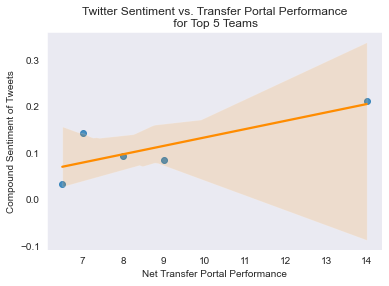

In [84]:
# Plot for winners
fig = sns.regplot(winners_net, winners_sen_scores, line_kws={"color": "darkorange"})
fig.set_xlabel("Net Transfer Portal Performance");
fig.set_ylabel("Compound Sentiment of Tweets");
fig.set_title("Twitter Sentiment vs. Transfer Portal Performance\n for Top 5 Teams");

In [85]:
# Equation of regression line above
stats.linregress(winners_net, winners_sen_scores)

LinregressResult(slope=0.017955336602944016, intercept=-0.04646428959938102, rvalue=0.8024946367733182, pvalue=0.10218757429086625, stderr=0.007707565469491325, intercept_stderr=0.07166378153976034)

/Users/dannymathieson/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


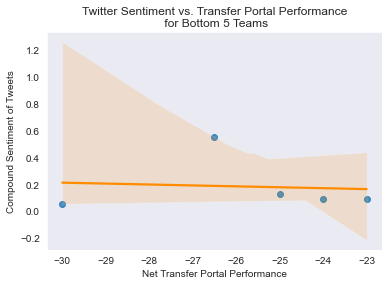

In [86]:
# Plot for losers
fig = sns.regplot(losers_net, losers_sen_scores,line_kws={"color": "darkorange"})
fig.set_xlabel("Net Transfer Portal Performance");
fig.set_ylabel("Compound Sentiment of Tweets");
fig.set_title("Twitter Sentiment vs. Transfer Portal Performance\n for Bottom 5 Teams");

In [87]:
ten_teams_sen_scores = []
for team in ten_teams:
    clean(team)
    ten_teams_sen_scores.append(sentiment(team.stemmed))

Pos: 0.12019354838709681
Neg: 0.029354838709677415
Neu: 0.8504516129032259
Compound: 0.21133225806451622
Pos: 0.040352941176470584
Neg: 0.0
Neu: 0.9596470588235294
Compound: 0.08495294117647058
Pos: 0.047980769230769216
Neg: 0.010515384615384617
Neu: 0.9415038461538464
Compound: 0.09400538461538464
Pos: 0.09066542750929367
Neg: 0.006832713754646842
Neu: 0.9025018587360589
Compound: 0.14331858736059463
Pos: 0.02461896080218777
Neg: 0.010605287146763892
Neu: 0.96478030993619
Compound: 0.03308185961713759
Pos: 0.048867435158501414
Neg: 0.02348703170028818
Neu: 0.9276484149855908
Compound: 0.05831152737752162
Pos: 0.2939534671532857
Neg: 0.02413229927007298
Neu: 0.681903284671522
Compound: 0.5535613138686132
Pos: 0.0909229074889869
Neg: 0.018438325991189424
Neu: 0.8906585903083711
Compound: 0.13139074889867786
Pos: 0.07806366047745363
Neg: 0.030619363395225474
Neu: 0.8913183023872697
Compound: 0.08944257294429672
Pos: 0.10691173794358501
Neg: 0.051100090991810766
Neu: 0.8419918107370348
Co

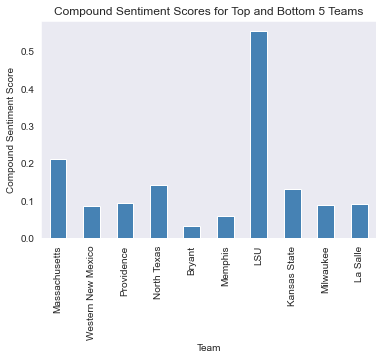

In [88]:
# Just a quick visualization of all teams sentiment scores
hist_df['sen']=ten_teams_sen_scores
hist_df
fig = hist_df.plot(y='sen',kind='bar',color = 'steelblue', legend=False)
fig.set_ylabel("Compound Sentiment Score");
fig.set_xlabel("Team");
fig.set_title("Compound Sentiment Scores for Top and Bottom 5 Teams");


/Users/dannymathieson/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


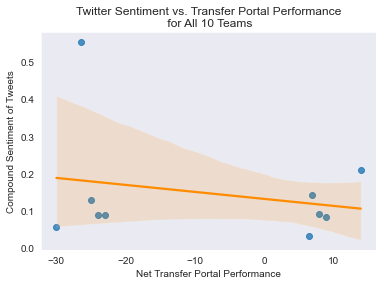

In [89]:
# Plot for all ten teams
fig = sns.regplot(ten_teams_net, ten_teams_sen_scores,line_kws={"color": "darkorange"})
fig.set_xlabel("Net Transfer Portal Performance");
fig.set_ylabel("Compound Sentiment of Tweets");
fig.set_title("Twitter Sentiment vs. Transfer Portal Performance\n for All 10 Teams");